## Finetune a GPT model with OpenAI API

This notebook explain how to finetune a GPT model using the OpenAI API. \
We will use a dataset containing articles and categories. We want that the model provides a specific category given an article.

In [ ]:
# !pip install datasets

### Task 1 - Set up the project environment

In [1]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


In [2]:
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

#### Open an OpenAI Client
We use the OpenAI Client to easily connect to OpenAI's models so we can send requests (like questions or prompts) and get answers back. 

In [3]:
client =  OpenAI(api_key=OPENAI_API_TOKEN)
client

### Task 2 - Prepare the training data

In [9]:
from datasets import load_dataset

df = load_dataset("Stefan171/TheGuardian-Articles")
df = df['train'].to_pandas()
df = df[['Article Contents', 'Article Category']][:900]
df.rename(columns={"Article Contents": "Contents", "Article Category": "Categories"}, inplace=True)
df


/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/Fine-Tuning_LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Contents,Categories
0,In the macho world of Mexican lucha libre wres...,Film
1,"Joey Harb possesses no fighting spirit, despit...",Books
2,"Dear President Erdoğan,\nWe wish to draw your ...",Opinion
3,The owners of Wilko took £3m in dividends this...,Business
4,One in five pregnancies are thought to end in ...,Life and style
...,...,...
895,"Opinion will always be divided, but a general ...",Sport
896,Guns N’ Roses are headlining Coachella – with ...,Film
897,Victoria’s peak legal body has chastised senio...,Australia news
898,The Nadesalingam family have said they finally...,Australia news


### Converting the Article records to json

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format (ChatFormat):

<pre>
<code>
{
  <span style="color: white;">"messages"</span>: [
    {
      <span style="color: white;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: white;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: white;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: white;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: white;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: white;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>

Let's define a method that get's a row of the dataframe and convert it into the json format

In [12]:
def save_as_json(row):

  system_content = """
      Given an article text, extract and return the topic of the article.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Contents},
            {"role": "assistant", "content": row.Categories}
        ]
      }

  with open("training_data.jsonl", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Now let's use of this method to generate the `training_data.json`

In [11]:
for index,row in df.iterrows():
    save_as_json(row)

### Task 3 - Fine-tune GPT 4 mini based on our training data

Let's import the json file we prepared as our training data

This code uploads a file named training_data.jsonl to OpenAI's servers using the client.files.create method. The purpose="fine-tune" specifies that the uploaded file will be used for fine-tuning a model, and the data_file variable stores the response, which includes details about the uploaded file (like its ID and status).

In [36]:
data_file = client.files.create(
    file = open("training_data.jsonl", "rb"),
    purpose= "fine-tune",
    )
data_file

FileObject(id='file-WhQR9hTEZRkdBZnv7pMXWa', bytes=5331090, created_at=1734451461, filename='training_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

Create the Fine Tuning Job

This code starts a fine-tuning job using OpenAI's API:

- training_file=data_file.id: It uses the id of the file you uploaded earlier (e.g., training_data.jsonl) as the dataset for fine-tuning.
- model="gpt-4o-mini-2024-07-18": Specifies the base model you want to fine-tune.
- hyperparameters={"n_epochs": "auto"}: Configures fine-tuning hyperparameters. Here, n_epochs="auto" lets OpenAI determine the optimal number of training passes over the dataset automatically.



- client.fine_tuning.jobs.create(...): Submits the fine-tuning job, and the result is stored in the fine_tuning_job variable, which contains the job details (e.g., status, job ID).

In [37]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=data_file.id, 
    model = "gpt-4o-mini-2024-07-18",
    hyperparameters={
        "n_epochs": "auto"
        }
    )

In [38]:
fine_tuning_job

FineTuningJob(id='ftjob-MNKKjrdOKPyFYfrOOuGxnPvi', created_at=1734451467, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Lqzv96QnFH3JDxxzx5j84wxT', result_files=[], seed=1297319778, status='validating_files', trained_tokens=None, training_file='file-WhQR9hTEZRkdBZnv7pMXWa', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

Let's retrieve the state of the fine-tune

In [39]:
while True:
    time.sleep(2)
    retrieve_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
    status = retrieve_job.status
    print(status)

    if (status == 'succeeded'):
        print('Done!')
        break

validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
queued
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


### Task 4 - Evaluate model

Let's retrieve the event messages to check out the learning process of our fine-tuning job.

In [40]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieve_job.id, limit = 100).data

[FineTuningJobEvent(id='ftevent-jY5rcxRCVnIeC8f7lkaORVb2', created_at=1734454209, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-6Jz3BhIhIhnPgbQ6FIkjGZSO', created_at=1734454202, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-EcT6sywoPZIkF71mdajTGmso', created_at=1734454202, level='info', message='Checkpoint created at step 1800', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-Bd9rH7aZWqdNlQHD0ijOrSRO', created_at=1734454202, level='info', message='Checkpoint created at step 900', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-Mcs3vl4V8HKQGOxGf2tJfBCf', created_at=1734454190, level='info', message='Step 2700/2700: training loss=0.00', object='fine_tuning.job.event', data={'step': 2700, 'train_loss': 0.000

In [41]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieve_job.id, limit = 100).data) #last 100 events

for e in events:
    print(e.message)

The job has successfully completed
New fine-tuned model created
Checkpoint created at step 1800
Checkpoint created at step 900
Step 2700/2700: training loss=0.00
Step 2699/2700: training loss=0.00
Step 2698/2700: training loss=0.00
Step 2697/2700: training loss=0.00
Step 2696/2700: training loss=0.00
Step 2695/2700: training loss=0.00
Step 2694/2700: training loss=0.00
Step 2693/2700: training loss=3.70
Step 2692/2700: training loss=0.00
Step 2691/2700: training loss=0.00
Step 2690/2700: training loss=0.00
Step 2689/2700: training loss=0.00
Step 2688/2700: training loss=0.00
Step 2687/2700: training loss=0.00
Step 2686/2700: training loss=0.00
Step 2685/2700: training loss=0.00
Step 2684/2700: training loss=0.04
Step 2683/2700: training loss=0.00
Step 2682/2700: training loss=0.01
Step 2681/2700: training loss=1.08
Step 2680/2700: training loss=0.00
Step 2679/2700: training loss=0.00
Step 2678/2700: training loss=0.00
Step 2677/2700: training loss=0.00
Step 2676/2700: training loss=0.0

Let's extract the training loss in each learning step

In [42]:
steps = []
train_loss = []

for e in events:
    if (e.data):
        steps.append(e.data['step'])
        train_loss.append(e.data['train_loss'])

Use a line chart to visualize the train_loss in each step

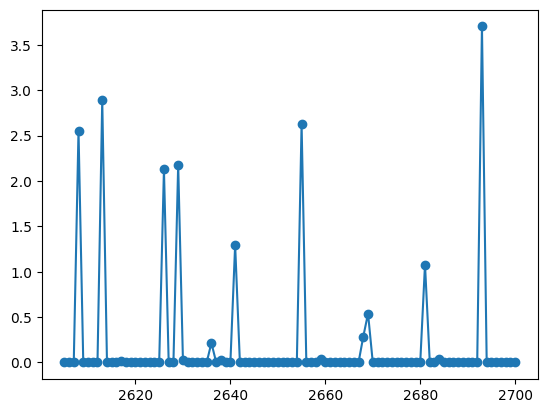

In [43]:
plt.plot(steps, train_loss, marker="o", linestyle= "-")

Let's take a look at `retrieved_job` again

retrieve_job

In [44]:
fine_tuned_model = retrieve_job.fine_tuned_model
fine_tuned_model

'ft:gpt-4o-mini-2024-07-18:personal::AfV3iuVR'

Defining a method to extract information from a given user article using a specific LLM and return the results.

In [45]:
def extract_details(user_article, model_name):
    """
    This function extracts topic from a given user article using a specific LLM (Large Language Model).

    Parameters:
    user_article (str): The text of the user's article.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given an article text, extract and return the topic of the article.
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_article}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content

Let's use our fine-tuned model to extract the details for the following user article

In [48]:
article = """Don Warrington is remembering crying in London’s Old Vic when he was a drama student. 
            “I hadn’t seen much Shakespeare. I didn’t know anything about anything really.” On stage was Eric Porter as King Lear. 
            “I sat there and I thought, ‘That miserable old git,’ but he was breaking my heart.” 
            Nearly half a century later, Warrington is to play the heartbreaking old git in a production directed by Michael Buffong, artistic director of Talawa, Britain’s leading black theatre company. 
            As we chat over samosas and deep-fried okra in an Indian restaurant, Warrington looks serene and sartorially elegant. 
            But nearly everything he says speaks of his trepidation about taking on the role. I can feel my blood pressure rising. 
            At the time it seemed crazy to say no. Now I wonder if I'm just crazy “The nicest thing about any job is being offered it,” he says. 
            “Then the reality begins to dawn. Suddenly we have dates! I can feel my blood pressure rising.” 
            He was offered the part after his critically hailed performance in Arthur Miller’s All My Sons at Manchester’s Royal Exchange two years ago. 
            “At the time it seemed crazy to say no. Now I wonder if I’m just crazy.” 
            He and Buffong recently went to see Simon Russell Beale play Lear at the National. 
            “I thought ‘Is this for me?’ Those are big shoes...” 
            He won’t be drawn on whether playing Lear is a bigger challenge than Strictly Come Dancing in 2008 (he went out in week five after losing a dance-off with Heather Small) but both clearly put him out of his comfort zone. 
            Don Warrington Photograph: Linda Nylind/The Guardian Warrington is only 63 and Lear, he points out, is supposed to be 80. 
            id he wonder what they were thinking when they cast him? “I always feel, ‘What were they thinking?’ In this case, though, I don’t think it’s a matter of age, because lots of young actors have played him. 
            Paul Scofield was in his 40s. The energy it requires is not necessarily an old man’s energy. I’m not an old man.” 
            Warrington has previous played disempowered, ageing men. He made his well-received directorial debut at the West Yorkshire Playhouse in Leeds with Mustapha Matura’s Rum and Coca Cola, a comedy about the three times winner of Trinidad’s coveted Calypso King crown reduced to busking on beaches. 
            And two years ago, he was Joe Keller in Arthur Miller’s All My Sons, an industrialist whose firm was accused of knowingly supplying faulty aircraft parts to the military during the second world war. 
            Let’s not forget either Warrington’s turn on BBC2’s Grumpy Old Men. You’ve long been in training to play Lear, I tell him. 
            “You see none of this has occurred to me! He [Keller] was king of his castle or he wanted to be. But he had committed a sin. 
            You could say that Lear commits a sin in that he does a very stupid thing – giving his kingdom away as a test to his children. 
            “The big question is why does he do it? And I don’t know the answer to that yet. Maybe he’s got Alzheimer’s – which makes him speak to us now because it’s what most of us dread. 
            And then why does he insist his daughters say they love him as a condition for getting their share of his kingdom? He’s putting himself in a position where they might say, ‘We don’t love you, you’re a fucking old tyrant’.” 
            Does any of it resonate as a father of two sons? “Am I an old tyrant? Well, you’d have to ask my family about that. I’m sure they’ll have a whole variety of opinions. No, I don’t think so. He’s not me but he can be some of me. I can be angry, I can want to kill people.” 
            Don Warrington in All My Sons at the Royal Exchange, Manchester, in 2013. Photograph: Jonathan Keenan Don Warrington was born in Trinidad, and might still be there but for the fact that his father, Basil Kydd, a local politician, died suddenly aged 48 in 1958 when Don was six. 
            His mother, Shirley, decided to make a new life in England. It took three weeks to cross the Atlantic. 
            “England was a real disappointment if I’m honest. It was painted in the colonies as this beautiful, golden, bright place and it was absolutely the opposite.” 
            In Newcastle, he and his brother were the only black kids in school: “I got called rude names but I’d stand up for myself. 
            I became a Geordie and got nicknamed the Young Pele because I was good at football. The teachers were worse. 
            One teacher thought he should stop me being left handed and asked if I’d learned to write up a tree.” 
            Being uprooted from his birthplace has given him a lifelong sense of loss. 
            “My mother’s generation had protection their children didn’t have because they were adults when they left. 
            We didn’t have a map, we had to make a new one, a new map of how to exist.” So that’s what he did. 
            “I saw On the Waterfront and wanted to be Marlon Brando. I thought I looked like him and I wanted to be just like that.” 
            Rising Damp: Frances de la Tour, Leonard Rossiter and Don Warrington in the much-loved sitcom, 1978. Photograph: ITV / Rex Features Aged 17, he got his first job at Flora Robson Playhouse as an assistant stage manager, then moved to London to train at the Drama Centre. 
            Soon after graduation he landed the role of town planning student Philip Smith in Eric Chappell’s play The Banana Box. By this stage, he had discovered there was another actor called Don Williams (he used his mother’s maiden name) – and so named himself after Newcastle’s Warrington Road, where he was raised. 
            In The Banana Box, he starred opposite seedy landlord Rupert Rigsby played by Leonard Rossiter. 
            When Chappell adapted his play as the TV sitcom Rising Damp in 1974, the two men reprised their roles, and Warrington became one of the most prominent black actors on British TV. At the time, Eric Chappell’s sitcom was a departure. In the 1970s there were scarcely any black performers on television. 
            This was the era in which Lenny Henry performed with the Black and White Minstrels and Rudolf T Walker was called “sambo” by Jack Smethurst in Love Thy Neighbour. 
            Warrington’s role was a breakthrough because Smith was enviable rather than ridiculous. Indeed, Smith was everything the landlord wanted to be – suave, well spoken and, most importantly, desirable to fellow tenant Miss Jones. 
            “I knew the world of Rising Damp because I grew up surrounded by white people and was used to prejudice,” Warrington says now. 
            “But I never expected it to catch fire like that.” If Warrington hasn’t quite emerged from the long shadow cast by the sitcom, it’s not for want of trying. 
            His TV credits include, C.A.T.S Eyes, Morse, New Street Law, Trial and Retribution, Manchild, Holby City, Casualty and Doctor Who. 
            On stage he has worked a great deal with Talawa, and has also starred in two fine National Theatre productions of plays by Kwame Kwei-Armah, Elmina’s Kitchen and Statement of Regret. 
            He has been one face of Kenco coffee in TV ads, but let’s not hold that against him. In 2008, he was awarded an MBE in the Queen’s Birthday Honours for his services to drama. I didn't go back to Trinidad for a long time. 
            When I did, I remembered tastes, smells … my senses carried that memory Are you glad your mother brought you to England? “That’s a tricky one. I can’t honestly say that I feel that. Because that journey she made with her children has had the most profound effect. 
            I wonder what I left behind.” Do you go back to Trinidad to find out? “I didn’t for a long time, I didn’t want to because I was scared about what it would do. When I did, I remembered things – tastes, smells. So at a very basic level, the body had carried that sense memory.” He has a sister who remained in Trinidad. 
            “When I see her I recognise something in her I would like to be. I feel a kind of loss, which is her absolute sense of knowing the ground on which she stands.” You don’t feel that in England? “I don’t. 
            Until we can all believe that England is ours, until we can feel part of the fabric, we will feel this slight distance between us and where we live. There will always be another place that is home.” Don Warrington plays King Lear from 1 April at the Royal Exchange, Manchester, and from 19 May at Birmingham Repertory Theatre"""

In [ ]:
extract_details(article, fine_tuned_model)

Let's test a `GPT-4` model with the same user article

In [ ]:
model = "gpt-4o-mini-2024-07-18"

extract_details(article, model)

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.